# Critical Path Method
Prepared by: Nickolas Freeman, Ph.D.

This notebook implements the critical path method that is commonly used for project scheduling when there are no resource contraints limiting the simultaneous processing of tasks. From https://en.wikipedia.org/wiki/Critical_path_method (accessed 9/26/2019):

> The critical path method (CPM), or critical path analysis (CPA), is an algorithm for scheduling a set of project activities. A critical path is determined by identifying the longest stretch [sequence] of dependent activities and measuring the time required to complete them from start to finish [makespan].

The follwoing code block imports several libraries that we will use.

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import warnings

The following code block reads in data for an 8-task project that we will use to demonstrate the method and stores the data in a Pandas `DataFrame` object that we call data. The task is used as the index. The data includes columns specifying the processing time for each task, and comma-separated sequences of predecessor and successor tasks. We add a '-' in the appropriate column for tasks that have no predecessors or successors.

In [2]:
data = pd.read_excel('CPM_Example1.xlsx')
data = data.set_index('Task')
data = data.fillna('-')
data

,pj,Predecessors,Successors
Task,,,
1,4,-,4
2,6,-,5
3,10,-,"6,7"
4,12,1,"6,7"
5,10,2,6
6,2,"3,4,5",8
7,4,"3,4",8
8,2,"6,7",-


The following code block converts the `data` object to a dictionary stored as `data_dict`. Then, we iterate over the dictionary converting the predecessor and successor columns to:

- an empty list if there are no predecessors or successors,
- a list including a single item if there is only one predecessor or successor, or
- a list of multiple items if there are multiple predecessors or successors.

**Note that we are requiring the keys of the `data_dict` object to be strings. This will make sure that our code will handle both numeric and text representations for task names.**

In [3]:
# convert the DataFrame to a dictionary, with keys
# populated using the DataFrame index
data_dict = data.to_dict(orient= 'index')

# for each task represented by the dictionary keys
for task in data_dict.keys():
    
    # for both the predecessors and successors
    for node_group in ['Predecessors','Successors']:
        
        # if there are no predecessors or successors
        if data_dict[task][node_group] == '-':
            
            # update to an empty list
            data_dict[task][node_group] = []
            
        # else if there is a single predecessor or successor
        elif len(str(data_dict[task][node_group]).split(',')) == 1:
            
            # update to a list with the single predecessor or successor
            data_dict[task][node_group] = [str(data_dict[task][node_group])]
        
        # else if there are more than one predecessors or successors
        else:
            
            # split on the commas to create a list with multiple items
            data_dict[task][node_group] = [str(task) for task in data_dict[task][node_group].split(',')]
            
# convert the dictionary keys to strings
data_dict = {str(key): value for key, value in data_dict.items()}

data_dict

{'1': {'pj': 4, 'Predecessors': [], 'Successors': ['4']},
 '2': {'pj': 6, 'Predecessors': [], 'Successors': ['5']},
 '3': {'pj': 10, 'Predecessors': [], 'Successors': ['6', '7']},
 '4': {'pj': 12, 'Predecessors': ['1'], 'Successors': ['6', '7']},
 '5': {'pj': 10, 'Predecessors': ['2'], 'Successors': ['6']},
 '6': {'pj': 2, 'Predecessors': ['3', '4', '5'], 'Successors': ['8']},
 '7': {'pj': 4, 'Predecessors': ['3', '4'], 'Successors': ['8']},
 '8': {'pj': 2, 'Predecessors': ['6', '7'], 'Successors': []}}

The following code block shows how we can use the `netwrokx` package to visualize the project dependencies.

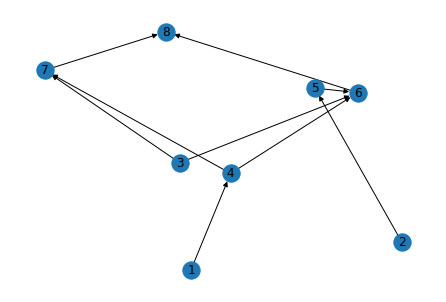

In [4]:
# create an empty directed network object
G = nx.DiGraph()

# for each task represented by the dictionary keys
for task in data_dict.keys():
    
    # add a node to the graph for the current task
    G.add_node(task)

# for each task represented by the dictionary keys
for task in data_dict.keys():
    
    # if the task has successors
    if len(data_dict[task]['Successors']) > 0:
        
        # for each sucessor
        for successor in data_dict[task]['Successors']:
            
            # add an edge from the task to the sucessor
            G.add_edge(task, successor)    

# catch warnings from the networkx package
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # draw the graph
    nx.draw_spring(G, with_labels = True)

The critical path method conducts two passes over the project network to identify activities that cannot be delayed with extending the total time required to complete the project. The *forward pass* is used to compute early start (ES) and early finish (EF) times for each task. The *backward pass* is used to compute late start (LS) and late finish (LF) times for each task. For a particular task, the difference (LS - ES) or (LF - EF) gives a measure of how much *float* is associated with the task. This float measure is equivalent to slack and gives an idea of how many time units a task can be delayed without extending the project. 

We will now start the forward pass. The first step will be to calculate the early start and early finish times for all tasks that have no predecessors. Such tasks can start immediately. Assuming that the project will start at time 0, the following code block updates the `data_dict` object to include the early start and early finish times for jobs without predecessors.

In [5]:
# specify the start time
start_time = 0

# initialize a list to store the remaining tasks
# to be handled during the forward pass
FP_Remaining_Tasks = list(data_dict.keys())

# for each task in the remaining tasks
for task in FP_Remaining_Tasks:
    
    # if the current task has no predecessors
    if data_dict[task]['Predecessors'] == []:
        
        # set the early start time equal to the start time
        data_dict[task]['ES'] = start_time
        
        # set the early finish time equal to the early start time
        # plus the processing time
        data_dict[task]['EF'] = start_time + data_dict[task]['pj']
        
        # remove the task from the list of remaing tasks
        FP_Remaining_Tasks.remove(task)

data_dict

{'1': {'pj': 4, 'Predecessors': [], 'Successors': ['4'], 'ES': 0, 'EF': 4},
 '2': {'pj': 6, 'Predecessors': [], 'Successors': ['5']},
 '3': {'pj': 10,
  'Predecessors': [],
  'Successors': ['6', '7'],
  'ES': 0,
  'EF': 10},
 '4': {'pj': 12, 'Predecessors': ['1'], 'Successors': ['6', '7']},
 '5': {'pj': 10, 'Predecessors': ['2'], 'Successors': ['6']},
 '6': {'pj': 2, 'Predecessors': ['3', '4', '5'], 'Successors': ['8']},
 '7': {'pj': 4, 'Predecessors': ['3', '4'], 'Successors': ['8']},
 '8': {'pj': 2, 'Predecessors': ['6', '7'], 'Successors': []}}

The following code block iterates over the remaining tasks, first checking whether all of the predecessors for a current task are completed. If this is true, the algorithm then uses the **maximum** early finish time of selected task's predecessors to specify the early start for the selected task.

In [6]:
# while there are still tasks to process
# in the forward pass
while len(FP_Remaining_Tasks) > 0:
    
    # for each remaining task
    for current_task in FP_Remaining_Tasks:
        
        # if the current task has predecessors
        if len(set(FP_Remaining_Tasks).intersection(set(data_dict[current_task]['Predecessors']))) == 0:
            
            # remove the current task from the remaing tasks
            FP_Remaining_Tasks.remove(current_task)
            
            # exit the for loop, with the current task still specified!
            break
    
    # get the predecessors of the current task
    predecessors = data_dict[current_task]['Predecessors']
    
    # initialize a variable to store the maximum early
    # finish time of the current task's predecessors
    max_ef = 0
    
    # for each predecessor
    for predecessor in predecessors:
        
        # if the early finish time of the predecessor is
        # larger than the maximum early finish time variable
        if (data_dict[predecessor]['EF'] > max_ef):
            
            # update the maximum early finish time variable
            max_ef = data_dict[predecessor]['EF']
    
    # set the early start time for the current task to
    # the value of the maxiumum early finish time variable
    data_dict[current_task]['ES'] = max_ef
    
    # calculate the current task's early finish time
    data_dict[current_task]['EF'] = data_dict[current_task]['ES'] + data_dict[current_task]['pj']

This completes the forward pass. The following code block prints the updated `data_dict` object to the screen.

In [7]:
data_dict

{'1': {'pj': 4, 'Predecessors': [], 'Successors': ['4'], 'ES': 0, 'EF': 4},
 '2': {'pj': 6, 'Predecessors': [], 'Successors': ['5'], 'ES': 0, 'EF': 6},
 '3': {'pj': 10,
  'Predecessors': [],
  'Successors': ['6', '7'],
  'ES': 0,
  'EF': 10},
 '4': {'pj': 12,
  'Predecessors': ['1'],
  'Successors': ['6', '7'],
  'ES': 4,
  'EF': 16},
 '5': {'pj': 10,
  'Predecessors': ['2'],
  'Successors': ['6'],
  'ES': 6,
  'EF': 16},
 '6': {'pj': 2,
  'Predecessors': ['3', '4', '5'],
  'Successors': ['8'],
  'ES': 16,
  'EF': 18},
 '7': {'pj': 4,
  'Predecessors': ['3', '4'],
  'Successors': ['8'],
  'ES': 16,
  'EF': 20},
 '8': {'pj': 2,
  'Predecessors': ['6', '7'],
  'Successors': [],
  'ES': 20,
  'EF': 22}}

We will now start the backward pass. The first step will be to calculate the late finish and late start times for all tasks that have no successors. The late finish time for these tasks is set to the maximum of the early finish times found during the forward pass, i.e., the makespan of the project. The following code block updates the `data_dict` object to include the late finish and late start times for jobs without predecessors.

In [8]:
# initialize a list to store the remaining tasks
# to be handled during the forward pass
BP_Remaining_Tasks = list(data_dict.keys())

# initialize a variable to store the maximum early
# finish time of all tasks
max_ef = 0

# for each task in the remaining tasks
for task in BP_Remaining_Tasks:
    
    # if the early finish time of the predecessor is
    # larger than the maximum early finish time variable 
    if data_dict[task]['EF'] > max_ef:
        
        # update the value of the maximum early finish time variable 
        max_ef = data_dict[task]['EF']

# for each task in the remaining tasks
for task in BP_Remaining_Tasks:
    
    # if the current task has no sucessors
    if data_dict[task]['Successors'] == []:
        
        # set the late finish time equal to the value of 
        # the maximum early finish time variable
        data_dict[task]['LF'] = max_ef
        
        # set the late start time equal to the late finish time
        # minus the processing time
        data_dict[task]['LS'] = max_ef - data_dict[task]['pj']
        
        # remove the task from the list of remaing tasks
        BP_Remaining_Tasks.remove(task)

data_dict

{'1': {'pj': 4, 'Predecessors': [], 'Successors': ['4'], 'ES': 0, 'EF': 4},
 '2': {'pj': 6, 'Predecessors': [], 'Successors': ['5'], 'ES': 0, 'EF': 6},
 '3': {'pj': 10,
  'Predecessors': [],
  'Successors': ['6', '7'],
  'ES': 0,
  'EF': 10},
 '4': {'pj': 12,
  'Predecessors': ['1'],
  'Successors': ['6', '7'],
  'ES': 4,
  'EF': 16},
 '5': {'pj': 10,
  'Predecessors': ['2'],
  'Successors': ['6'],
  'ES': 6,
  'EF': 16},
 '6': {'pj': 2,
  'Predecessors': ['3', '4', '5'],
  'Successors': ['8'],
  'ES': 16,
  'EF': 18},
 '7': {'pj': 4,
  'Predecessors': ['3', '4'],
  'Successors': ['8'],
  'ES': 16,
  'EF': 20},
 '8': {'pj': 2,
  'Predecessors': ['6', '7'],
  'Successors': [],
  'ES': 20,
  'EF': 22,
  'LF': 22,
  'LS': 20}}

The following code block iterates over the remaining tasks, first checking whether all of the sucessessors for a current task are completed. If this is true, the algorithm then uses the **minimum** late start time of the selected task's successors to specify the late finish time for the selected task.

In [9]:
# while there are still tasks to process
# in the backward pass
while len(BP_Remaining_Tasks) > 0:
    
    # for each remaining task
    for current_task in BP_Remaining_Tasks:
        
        # if the current task has successors
        if len(set(BP_Remaining_Tasks).intersection(set(data_dict[current_task]['Successors']))) == 0:
            
            # remove the current task from the remaing tasks
            BP_Remaining_Tasks.remove(current_task)
            
            # exit the for loop, with the current task still specified!
            break
    
    # get the successors of the current task
    successors = data_dict[current_task]['Successors']
    
    # initialize a variable to store the minimum late
    # start time of the current task's successors.
    # Set the variable to infinity
    min_ls = np.inf
    
    # for each sucessor
    for successor in successors:
        
        # if the late start time of the successor is
        # less than the minimum late start time variable
        if (data_dict[successor]['LS'] < min_ls):
            
            # update the maximum early finish time variable
            min_ls = data_dict[successor]['LS']
            
    # set the late finish time for the current task to
    # the value of the minimum late start time variable
    data_dict[current_task]['LF'] = min_ls
    
    # calculate the current task's late start time
    data_dict[current_task]['LS'] = data_dict[current_task]['LF'] - data_dict[current_task]['pj']

This completes the backward pass. The following code block prints the updated `data_dict` object to the screen.

In [10]:
data_dict

{'1': {'pj': 4,
  'Predecessors': [],
  'Successors': ['4'],
  'ES': 0,
  'EF': 4,
  'LF': 4,
  'LS': 0},
 '2': {'pj': 6,
  'Predecessors': [],
  'Successors': ['5'],
  'ES': 0,
  'EF': 6,
  'LF': 8,
  'LS': 2},
 '3': {'pj': 10,
  'Predecessors': [],
  'Successors': ['6', '7'],
  'ES': 0,
  'EF': 10,
  'LF': 16,
  'LS': 6},
 '4': {'pj': 12,
  'Predecessors': ['1'],
  'Successors': ['6', '7'],
  'ES': 4,
  'EF': 16,
  'LF': 16,
  'LS': 4},
 '5': {'pj': 10,
  'Predecessors': ['2'],
  'Successors': ['6'],
  'ES': 6,
  'EF': 16,
  'LF': 18,
  'LS': 8},
 '6': {'pj': 2,
  'Predecessors': ['3', '4', '5'],
  'Successors': ['8'],
  'ES': 16,
  'EF': 18,
  'LF': 20,
  'LS': 18},
 '7': {'pj': 4,
  'Predecessors': ['3', '4'],
  'Successors': ['8'],
  'ES': 16,
  'EF': 20,
  'LF': 20,
  'LS': 16},
 '8': {'pj': 2,
  'Predecessors': ['6', '7'],
  'Successors': [],
  'ES': 20,
  'EF': 22,
  'LF': 22,
  'LS': 20}}

The following code block computes and plots the critical path.

Task 1 is on the critical path
Task 4 is on the critical path
Task 7 is on the critical path
Task 8 is on the critical path
The length of the critical path is 22


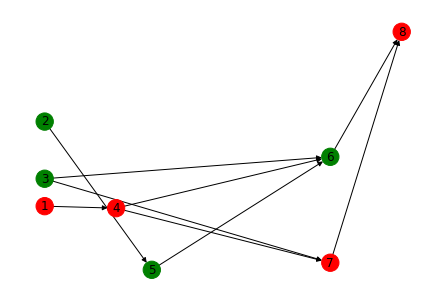

In [11]:
color_map = []
positions = {}

np.random.seed(0)
for node in G.nodes:
    positions[node] = np.array([data_dict[node]['ES'], np.random.uniform(low=-1.0, high=1.0)])
    if data_dict[node]['ES'] == data_dict[node]['LS']:
        color_map.append('red')
        print(f'Task {node} is on the critical path')
    else: 
        color_map.append('green')  
 
print(f'The length of the critical path is {max_ef}')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    nx.draw(G,
            node_color = color_map,
            pos=positions, 
            with_labels = True)

The following code block defines a function that accepts a dictionary object in the form that we used early. The function computes and returns the critical path and the project makespan as a tuple. The optional `include_plot` object allows you to generate a plot of the network with nodes on the critical path colored red. 

In [12]:
def determine_critical_path(data_dictionary, start_time = 0, include_plot = False):
    '''
    This function compute the critical path and makespan for a specified project. The 
    function expects a dictionary object (data_dictionary). The dictionary keys should
    be the names of the tasks, formatted as strings (even if the names are numeric). The 
    value for each key should be another dictionary with keys 'pj', 'Predecessors', and 
    and 'Successors'. The 'pj' value should be a number representing the task duration.
    The 'Predecessors' value should be a python list specifying the tasks that precede the
    associated task (formatted as strings). The 'Successors' value should be a python list 
    specifying the tasks that follow the associated task (formatted as strings). An empty list
    should be provided for the 'Predecessors'('Successors') value for all tasks that have no 
    predecessors(successors). An example of a valid dictionary object follows:
    
    {'1': {'pj': 4, 'Predecessors': [], 'Successors': ['4']},
     '2': {'pj': 6, 'Predecessors': [], 'Successors': ['5']},
     '3': {'pj': 10, 'Predecessors': [], 'Successors': ['6', '7']},
     '4': {'pj': 12, 'Predecessors': ['1'], 'Successors': ['6', '7']},
     '5': {'pj': 10, 'Predecessors': ['2'], 'Successors': ['6']},
     '6': {'pj': 2, 'Predecessors': ['3', '4', '5'], 'Successors': ['8']},
     '7': {'pj': 4, 'Predecessors': ['3', '4'], 'Successors': ['8']},
     '8': {'pj': 2, 'Predecessors': ['6', '7'], 'Successors': []}}
     
     The optional start_time argument specifies the time that the project starts.
     The optional include_plot argument should be set to True or False to indicate
     whether or not a plot of the project should be drawn. If a plot is drawn, tasks
     on the critical path will be colored red. Non-critical tasks will be colored green.   
     
    
    '''
    
    FP_Remaining_Tasks = list(data_dictionary.keys())

    for task in FP_Remaining_Tasks:
        if data_dictionary[task]['Predecessors'] == []:
            data_dictionary[task]['ES'] = start_time
            data_dictionary[task]['EF'] = start_time + data_dictionary[task]['pj']
            FP_Remaining_Tasks.remove(task)
            
    while len(FP_Remaining_Tasks) > 0:
        for current_task in FP_Remaining_Tasks:
            if len(set(FP_Remaining_Tasks).intersection(set(data_dictionary[current_task]['Predecessors']))) == 0:
                FP_Remaining_Tasks.remove(current_task)
                break

        predecessors = data_dictionary[current_task]['Predecessors']
        max_ef = 0
        for predecessor in predecessors:
            if (data_dictionary[predecessor]['EF'] > max_ef):
                max_ef = data_dictionary[predecessor]['EF']
        data_dictionary[current_task]['ES'] = max_ef
        data_dictionary[current_task]['EF'] = data_dictionary[current_task]['ES'] + data_dictionary[current_task]['pj']
        
    BP_Remaining_Tasks = list(data_dictionary.keys())
    max_ef = 0
    for task in BP_Remaining_Tasks:
        if data_dictionary[task]['EF'] > max_ef:
            max_ef = data_dictionary[task]['EF']

    for task in BP_Remaining_Tasks:
        if data_dictionary[task]['Successors'] == []:
            data_dictionary[task]['LF'] = max_ef
            data_dictionary[task]['LS'] = max_ef - data_dictionary[task]['pj']
            BP_Remaining_Tasks.remove(task)
            
    while len(BP_Remaining_Tasks) > 0:
        for current_task in BP_Remaining_Tasks:
            if len(set(BP_Remaining_Tasks).intersection(set(data_dictionary[current_task]['Successors']))) == 0:
                BP_Remaining_Tasks.remove(current_task)
                break

        successors = data_dictionary[current_task]['Successors']
        min_ls = np.inf
        for successor in successors:
            if (data_dictionary[successor]['LS'] < min_ls):
                min_ls = data_dictionary[successor]['LS']
        data_dictionary[current_task]['LF'] = min_ls
        data_dictionary[current_task]['LS'] = data_dictionary[current_task]['LF'] - data_dictionary[current_task]['pj']
        
    critical_path = []
    for key in data_dictionary:
        if data_dictionary[key]['ES'] == data_dictionary[key]['LS']:
            critical_path.append(key)
    
    if include_plot:    
        color_map = []
        positions = {}
        
        G = nx.DiGraph()
        for task in data_dict.keys():
            G.add_node(task, p = data_dict[task]['pj'])

        for task in data_dict.keys():
            if len(data_dict[task]['Successors']) > 0:
                for successor in data_dict[task]['Successors']:
                    G.add_edge(task, successor)   

        np.random.seed(0)
        for node in G.nodes:
            positions[node] = np.array([data_dictionary[node]['ES'], np.random.uniform(low=-1.0, high=1.0)])
            if data_dictionary[node]['ES'] == data_dictionary[node]['LS']:
                color_map.append('red')
            else: 
                color_map.append('green')  

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            nx.draw(G,
                    node_color = color_map,
                    pos=positions, 
                    with_labels = True)
    
    return critical_path, max_ef

The following code block demonstrates the use of the function with the `include_plot` option set to `True`.

In [13]:
determine_critical_path(data_dict, include_plot = False)

(['1', '4', '7', '8'], 22)

The following code block demonstrates the use of the function with the `include_plot` option set to `False`.

(['1', '4', '7', '8'], 22)

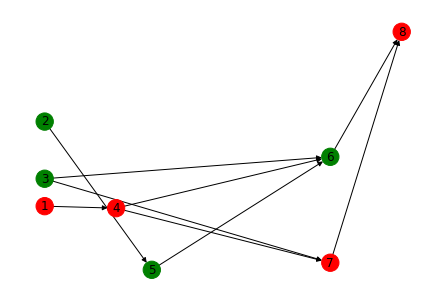

In [14]:
determine_critical_path(data_dict, include_plot = True)

The following code block demonstrate the complete process for preparing data and applying the critical path function to a new dataset with a project start time of 20.

(['B', 'X', 'F', 'S', 'K', 'U'], 66)

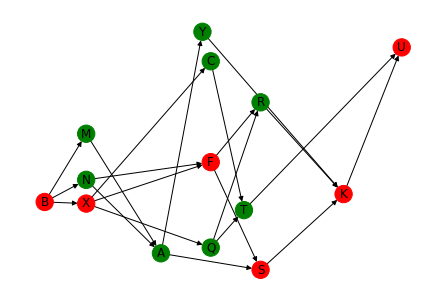

In [15]:
data = pd.read_excel('CPM_Example2.xlsx')
data = data.set_index('Task')
data = data.fillna('-')

data_dict = data.to_dict(orient= 'index')

for task in data_dict.keys():
    for node_group in ['Predecessors','Successors']:
        if data_dict[task][node_group] == '-':
            data_dict[task][node_group] = []
        elif len(str(data_dict[task][node_group]).split(',')) == 1:
            data_dict[task][node_group] = [str(data_dict[task][node_group])]
        else:
            data_dict[task][node_group] = [str(task) for task in data_dict[task][node_group].split(',')]
data_dict = {str(key): value for key, value in data_dict.items()}

determine_critical_path(data_dict, start_time = 20, include_plot = True)